__1. Обучить алгоритмы LightGBM, XGBoost и CatBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.__

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
path_dir = "data/competition_data/"

train = pd.read_csv(path_dir + "train.csv")
test = pd.read_csv(path_dir + "test.csv")
bki = pd.read_csv(path_dir + "bki.csv")
client_profile = pd.read_csv(path_dir + "client_profile.csv")
payments = pd.read_csv(path_dir + "payments.csv")

In [3]:
def simple_merge_dfs(df):
    df = df.merge(bki, how="left", on="APPLICATION_NUMBER")
    df = df.merge(client_profile, how="left", on="APPLICATION_NUMBER")
    df = df.merge(payments, how="left", on="APPLICATION_NUMBER")
    return df

In [4]:
train = simple_merge_dfs(train)
test = simple_merge_dfs(test)

print(f"Train.shape = {train.shape}")
print(f"Test.shape = {test.shape}")

Train.shape = (1086422, 49)
Test.shape = (1630923, 48)


In [5]:
train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,5640206.0,Closed,currency 1,2562.0,0.0,2197.0,2162.0,...,0.0,0.0,2.0,49796018.0,1.0,4.0,2830.0,2830.0,3289.635,3289.635
1,123687442,0,Cash,5640206.0,Closed,currency 1,2562.0,0.0,2197.0,2162.0,...,0.0,0.0,2.0,49796018.0,1.0,7.0,2740.0,2740.0,3289.635,3289.635
2,123687442,0,Cash,5640206.0,Closed,currency 1,2562.0,0.0,2197.0,2162.0,...,0.0,0.0,2.0,49713743.0,1.0,5.0,2551.0,2547.0,9262.215,9251.865
3,123687442,0,Cash,5640206.0,Closed,currency 1,2562.0,0.0,2197.0,2162.0,...,0.0,0.0,2.0,49713743.0,1.0,7.0,2491.0,2519.0,9262.215,10.350
4,123597908,1,Cash,5970760.0,Closed,currency 1,1809.0,0.0,1475.0,1503.0,...,NaN,NaN,NaN,49672074.0,1.0,9.0,450.0,457.0,11349.900,11349.900


In [6]:
def lightgbm_cross_validation(params, X, y, cv, categorical=None, groups=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if categorical:
        X[categorical] = X[categorical].astype('category')

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=0, early_stopping_rounds=5000,
#             categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
    print("=" * 30)
    print(time.ctime())
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical=None, groups=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=5000,
            early_stopping_rounds=10,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=0
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
        folds_scores.append(score)
    print("=" * 30)
    print(time.ctime())
    return estimators, encoders, oof_preds


def catboost_cross_validation(params, X, y, cv, categorical=None, groups=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)], 
            silent=True
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
    print("=" * 30)
    print(time.ctime())
    return estimators, oof_preds

In [7]:
lgb_params = {
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
    'silent': -1,
    'verbose': -1
}

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.2",
    "max_depth": 6,
    "gamma": 20,
    "subsample": 0.5,
    "colsample_bytree": 0.6,
    "colsample_bylevel": 0.632,
    "min_child_weight": 20,
    "tree_method": "approx",
    "alpha": 0.02,
    "lambda": 0.5,
    "nthread": -1,
    "random_seed": 27
}

cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": -1,
    "random_seed": 27
}

In [8]:
cv = GroupKFold(n_splits=6)
target_train, data_train = train["TARGET"], train.drop(["APPLICATION_NUMBER", "TARGET"], axis=1)
data_test = test.drop(["APPLICATION_NUMBER"], axis=1)

In [9]:
categorical_features = data_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [10]:
estimators_lgb, oof_preds_lgb = lightgbm_cross_validation(lgb_params, 
                                                          data_train, 
                                                          target_train, 
                                                          cv, 
                                                          categorical=categorical_features, 
                                                          groups=train["APPLICATION_NUMBER"])

Wed Dec 30 03:34:40 2020, Cross-Validation, 1086422 rows, 47 cols
Fold 1, Valid score = 0.69624
Fold 2, Valid score = 0.72329
Fold 3, Valid score = 0.71507
Fold 4, Valid score = 0.73024
Fold 5, Valid score = 0.70912
Fold 6, Valid score = 0.70177
Wed Dec 30 03:39:52 2020


In [11]:
estimators_xgb, encoders_xgb, oof_preds_xgb = xgboost_cross_validation(xgb_params,
                                                                       data_train,
                                                                       target_train,
                                                                       cv,
                                                                       categorical=categorical_features,
                                                                       groups=train["APPLICATION_NUMBER"])

Wed Dec 30 03:39:56 2020, Cross-Validation, 1086422 rows, 47 cols
Fold 1, Valid score = 0.68139
Fold 2, Valid score = 0.71458
Fold 3, Valid score = 0.7175
Fold 4, Valid score = 0.72583
Fold 5, Valid score = 0.70461
Fold 6, Valid score = 0.69243
Wed Dec 30 03:48:06 2020


In [12]:
estimators_cb, oof_preds_cb = catboost_cross_validation(cb_params,
                                                        data_train,
                                                        target_train,
                                                        cv,
                                                        categorical=categorical_features,
                                                        groups=train["APPLICATION_NUMBER"])

Wed Dec 30 03:48:06 2020, Cross-Validation, 1086422 rows, 47 cols
Fold 1, Valid score = 0.69982
Fold 2, Valid score = 0.71528
Fold 3, Valid score = 0.71451
Fold 4, Valid score = 0.70767
Fold 5, Valid score = 0.69531
Fold 6, Valid score = 0.69874
Wed Dec 30 04:17:09 2020


In [13]:
scores_train = pd.DataFrame({
    "lgbm": oof_preds_lgb,
    "xgb": oof_preds_xgb,
    "cb" :oof_preds_cb,
})

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

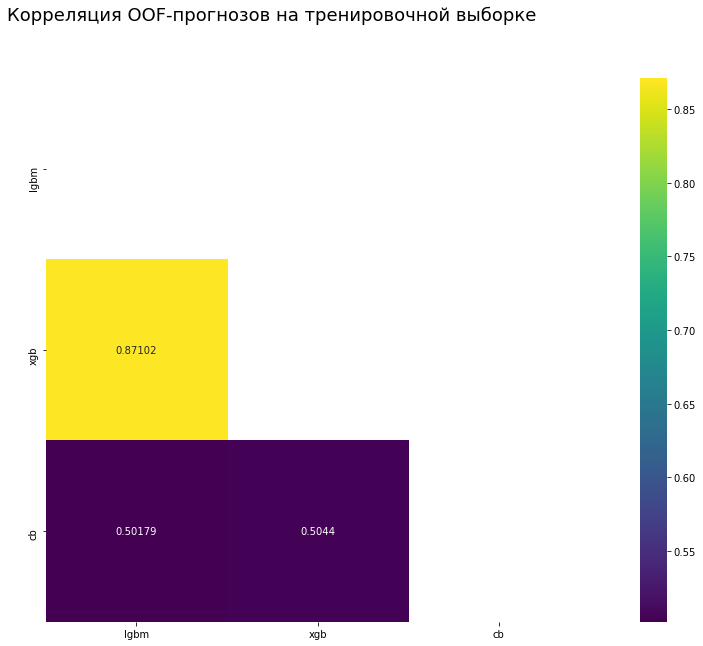

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(18, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".5g", square=True, cmap="viridis", ax=axes)
fig.suptitle("Корреляция OOF-прогнозов на тренировочной выборке", fontsize=18);

In [15]:
def get_df_lgb_predictions(df, categorical_features=None):
    df[categorical_features] = df[categorical_features].astype('category')
    
    return df


def get_df_xgb_predictions(df, categorical_features=None, encoders=None):

    for (feature, encoder) in encoders.items():
        encoder_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        
        df[feature] = df[feature].astype("str").fillna("NA")
        df.loc[~df[feature].isin(encoder_dict.values()), feature] = list(encoder_dict.keys())[0]
        
        df[feature] = encoder.transform(df[feature])
    return xgb.DMatrix(df)

In [16]:
fig_train_x = get_df_lgb_predictions(data_train, categorical_features=categorical_features)

lgb_scores = {f"lgb_{n}-estimator": estimator.predict_proba(fig_train_x)[:, 1] for n, estimator in enumerate(estimators_lgb)}

In [17]:
fig_train_x = get_df_xgb_predictions(data_train, categorical_features=categorical_features, encoders=encoders_xgb)

xgb_scores = {f"xgb_{n}-estimator": estimator.predict(fig_train_x) for n, estimator in enumerate(estimators_xgb)}

In [18]:
cb_scores = {f"cb_{n}-estimator": estimator.predict_proba(data_train)[:, 1] for n, estimator in enumerate(estimators_cb)}

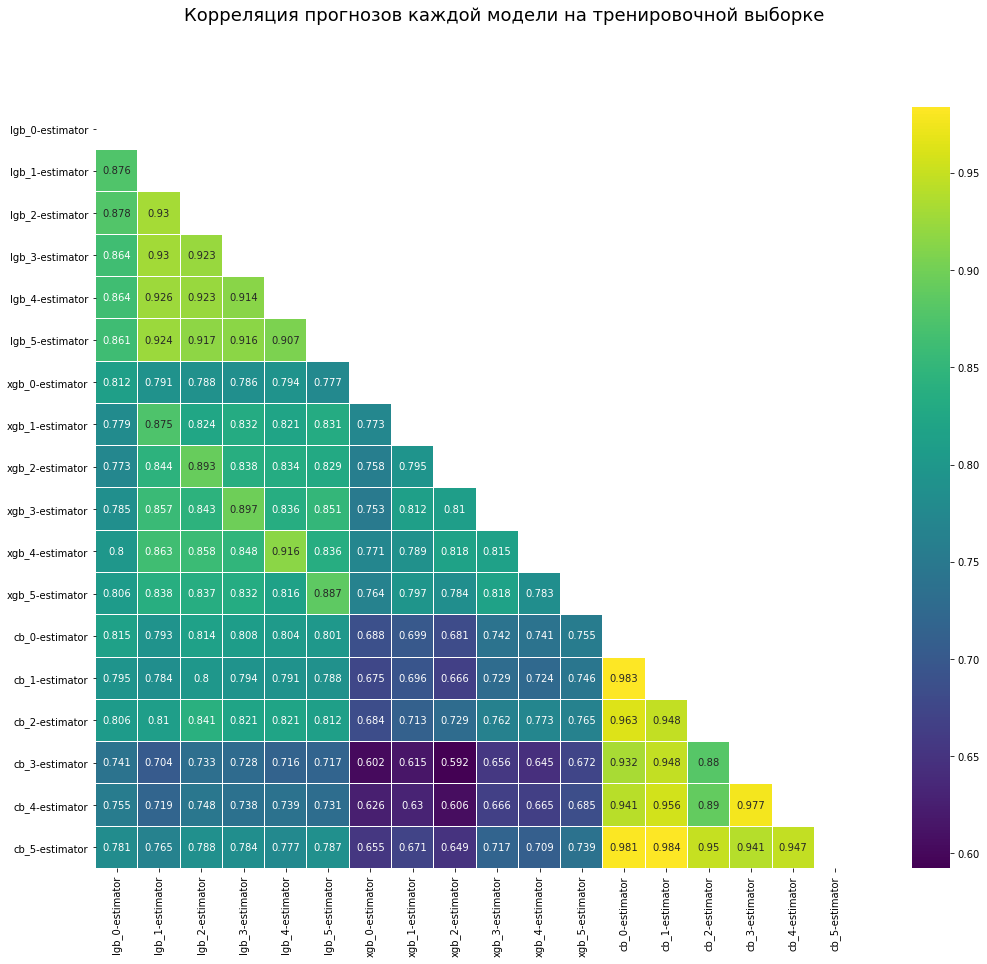

In [19]:
concat_scores = {}
concat_scores.update(lgb_scores)
concat_scores.update(xgb_scores)
concat_scores.update(cb_scores)

scores_estimators = pd.DataFrame(concat_scores)

corr = scores_estimators.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(20, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".3g", square=True, cmap="viridis", ax=axes, linewidths=0.05)
fig.suptitle("Корреляция прогнозов каждой модели на тренировочной выборке", fontsize=18);

У моделей высокая корреляция внутри одного алгоритма на разных фолдах, и низкая между алгоритмами. Самая низкая корреляцию у CatBoost'а и XGBoost'а. Корреляция прогнозов CatBoost'а и LightGBM'а выше, чем у XGBoost'а и LightGBM'а.

In [20]:
fig_test_x = get_df_lgb_predictions(data_test, categorical_features=categorical_features)

lgb_scores = {f"lgb_{n}-estimator": estimator.predict_proba(fig_test_x)[:, 1] for n, estimator in enumerate(estimators_lgb)}

In [21]:
fig_test_x = get_df_xgb_predictions(data_test, categorical_features=categorical_features, encoders=encoders_xgb)

xgb_scores = {f"xgb_{n}-estimator": estimator.predict(fig_test_x) for n, estimator in enumerate(estimators_xgb)}

In [22]:
cb_scores = {f"cb_{n}-estimator": estimator.predict_proba(data_test)[:, 1] for n, estimator in enumerate(estimators_cb)}

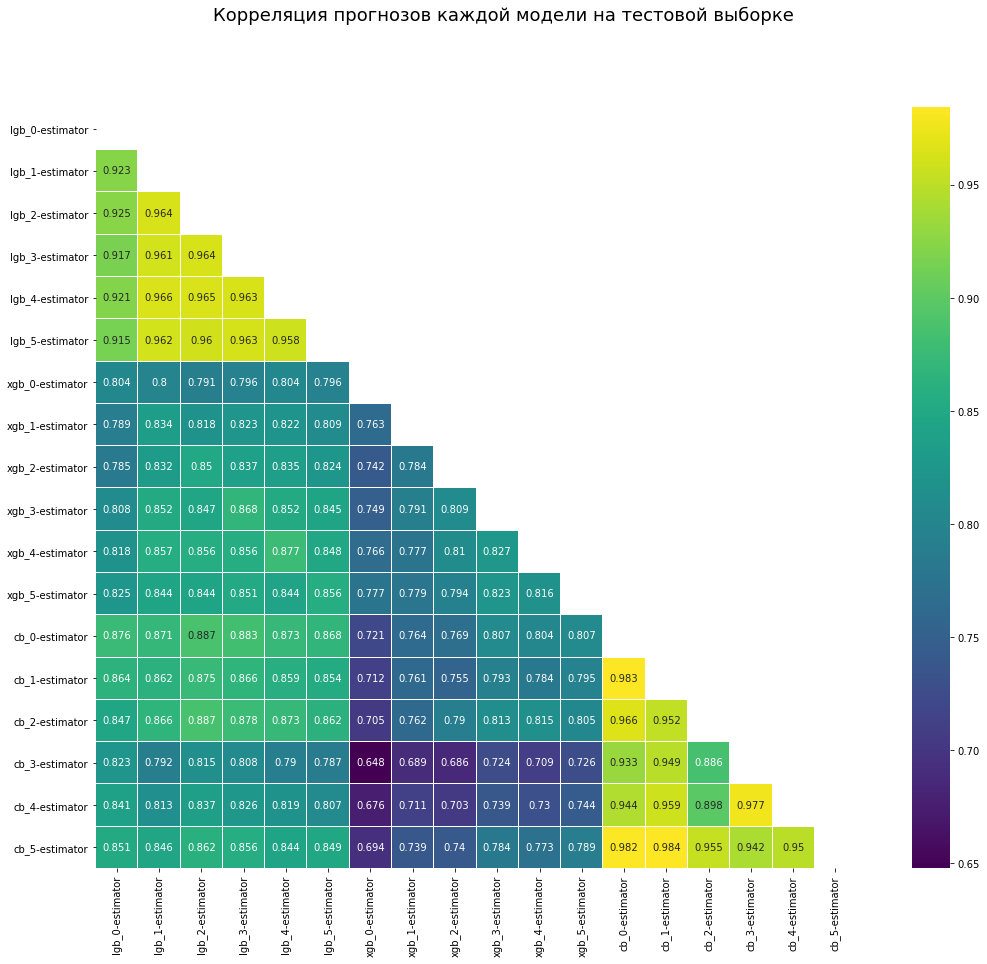

In [23]:
concat_scores = {}
concat_scores.update(lgb_scores)
concat_scores.update(xgb_scores)
concat_scores.update(cb_scores)

scores_estimators = pd.DataFrame(concat_scores)

corr = scores_estimators.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(20, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".3g", square=True, cmap="viridis", ax=axes, linewidths=0.05)
fig.suptitle("Корреляция прогнозов каждой модели на тестовой выборке", fontsize=18);

Корреляция прогнозов на тестовой выборке дает похожую картину, но у XGBoost'а меньшая корреляция, даже между своими моделями разных фолдов.

__2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.__

In [24]:
n_digits = 5

amean_lgb_xgb = scores_train[['lgbm', 'xgb']].mean(axis=1)
print(f"Amean lgb and xgb score = {round(roc_auc_score(target_train, amean_lgb_xgb), n_digits)}")

gmean_lgb_xgb = gmean(scores_train[['lgbm', 'xgb']], axis=1)
print(f"Gmean lgb and xgb score = {round(roc_auc_score(target_train, gmean_lgb_xgb), n_digits)}")

rank_lgb_xgb = scores_train[['lgbm', 'xgb']].rank().mean(axis=1)
print(f"Rank lgb and xgb score = {round(roc_auc_score(target_train, rank_lgb_xgb), n_digits)}")

print("-" * 30)
amean_lgb_xgb_cb = scores_train.mean(axis=1)
print(f"Amean lgb, xgb and cb score = {round(roc_auc_score(target_train, amean_lgb_xgb_cb), n_digits)}")

gmean_lgb_xgb_cb = gmean(scores_train, axis=1)
print(f"Gmean lgb, xgb and cb score = {round(roc_auc_score(target_train, gmean_lgb_xgb_cb), n_digits)}")

rank_lgb_xgb_cb = scores_train.rank().mean(axis=1)
print(f"Rank lgb, xgb and cb score = {round(roc_auc_score(target_train, rank_lgb_xgb_cb), n_digits)}")

Amean lgb and xgb score = 0.70978
Gmean lgb and xgb score = 0.70999
Rank lgb and xgb score = 0.7097
------------------------------
Amean lgb, xgb and cb score = 0.69283
Gmean lgb, xgb and cb score = 0.7061
Rank lgb, xgb and cb score = 0.70548


CatBoost и LightGBM выше, чем у XGBoost
Усреднение прогнозов дает хороший результат для LightGBM и XGBoost, геометрическое среднее - лидер. Усреднение прогнозов для LightGBM, XGBoost и CatBoost дает неплохой результат, но ниже, чем с 2-ми моделями. Среднее значение упало из-за CatBoost, так как у модели качество ниже (но алгоритм меньше подвержен переобучению). Усреднение рангов дает худший результат для данных моделей.

__3. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 для LightGBM и XGBoost и для LightGBM, XGBoost и CatBoost.__

In [25]:
threshold = 0.5
pred_models = pd.DataFrame(np.zeros(scores_train.shape), columns=scores_train.columns).astype(int)
for column in scores_train:
    indexes = scores_train.loc[scores_train[column]>threshold, column].index
    pred_models[column][indexes] = 1

In [26]:
for intercept in [True, False]:
    print("With intercept:" if intercept else "Without intercept:")
    print("Logistic Regression for LightGBM и XGBoost:")
    lr = LogisticRegression(n_jobs=-1, 
                            penalty="none", 
                            fit_intercept=intercept, 
                            random_state=27).fit(scores_train[['lgbm', 'xgb']], target_train)

    print(f"Score = {roc_auc_score(target_train, lr.predict(scores_train[['lgbm', 'xgb']]))}")
    print(f"Weights = {lr.coef_}")
    print(f"Intercept = {lr.intercept_}\n")

    print("Logistic Regression for LightGBM, XGBoost and CatBoost:")
    lr = LogisticRegression(n_jobs=-1, 
                            penalty="none", 
                            fit_intercept=intercept, 
                            random_state=27).fit(scores_train, target_train)

    print(f"Score = {roc_auc_score(target_train, lr.predict(scores_train))}")
    print(f"Weights = {lr.coef_}")
    print(f"Intercept = {lr.intercept_}")
    print("=" * 40, "\n")

With intercept:
Logistic Regression for LightGBM и XGBoost:
Score = 0.5175283749265152
Weights = [[5.15565892 4.36146443]]
Intercept = [-3.31589059]

Logistic Regression for LightGBM, XGBoost and CatBoost:
Score = 0.5173605832138322
Weights = [[4.68555336 4.03125325 1.27760559]]
Intercept = [-3.42119259]

Without intercept:
Logistic Regression for LightGBM и XGBoost:
Score = 0.5036766992162317
Weights = [[-35.51715075  11.62644225]]
Intercept = [0.]

Logistic Regression for LightGBM, XGBoost and CatBoost:
Score = 0.503024822427231
Weights = [[-17.04908454  14.54313095 -14.79035143]]
Intercept = [0.]



Качество логистической регрессии ниже любой из моделей, но использование регрессии позволяет получить веса предсказаний по моделям, которые можно использовать для взвешанного усреднения моделей.

__4. (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 3.__

In [27]:
rfr_params = {
    "n_estimators": 400, 
    "min_samples_split": 50,
    "min_samples_leaf": 20,
    "max_depth": 8, 
    "n_jobs": -1, 
    "bootstrap": True,
    "random_state": 27,
    "verbose": 0
}

In [31]:
def random_forest_cross_validation(params, X, y, cv, groups):
    
    X = X.fillna(-9999)
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    print("=" * 30)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = RandomForestClassifier(**params)
        model.fit(x_train, y_train)
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
    print("=" * 30)
    print(time.ctime())
    return estimators, oof_preds

In [32]:
estimators_rfr, oof_preds_rfr = random_forest_cross_validation(rfr_params,
                                                               data_train,
                                                               target_train,
                                                               cv, 
                                                               train["APPLICATION_NUMBER"])

Wed Dec 30 11:47:24 2020, Cross-Validation, 1086422 rows, 47 cols
Fold 1, Valid score = 0.68508
Fold 2, Valid score = 0.70383
Fold 3, Valid score = 0.69232
Fold 4, Valid score = 0.70516
Fold 5, Valid score = 0.69104
Fold 6, Valid score = 0.68575
Wed Dec 30 12:00:35 2020


In [33]:
scores_train["rfr"] = oof_preds_rfr

In [34]:
for intercept in [True, False]:
    print("With intercept:" if intercept else "Without intercept:")
    print("Logistic Regression for LightGBM, XGBoost, CatBoost and RandomForest:")
    lr = LogisticRegression(n_jobs=-1, 
                            penalty="none", 
                            fit_intercept=intercept, 
                            random_state=27).fit(scores_train, target_train)

    print(f"Score = {roc_auc_score(target_train, lr.predict(scores_train))}")
    print(f"Weights = {lr.coef_}")
    print(f"Intercept = {lr.intercept_}\n")
    print("=" * 40, "\n")

With intercept:
Logistic Regression for LightGBM, XGBoost, CatBoost and RandomForest:
Score = 0.515979272412686
Weights = [[2.93990948 2.66166672 0.28826979 7.77333046]]
Intercept = [-3.6999932]


Without intercept:
Logistic Regression for LightGBM, XGBoost, CatBoost and RandomForest:
Score = 0.5112198738286434
Weights = [[  2.63772826  17.4012269   -5.03982997 -39.22927681]]
Intercept = [0.]




Качество логистической регрессии незначительно выросло, за счет RandomForest модели, у которой качество хуже бустинговых для данного примера. Коэффициенты регрессии показывают малую значимость RandomForest'а в ансамбле алгоритмов.